The IEEE-CIS Fraud Detection dataset

It contains anonymized transactional data with a mixture of numerical, categorical, and identity features collected from real-world e-commerce transactions. The goal is to predict fraudulent transactions (labelled as isFraud) based on various behavioral and transactional patterns.

Key characteristics of the dataset include:

> Over 590,000 transactions with hundreds of features capturing transaction details and user identity.
> A significant class imbalance, as fraud cases represent a small fraction of total transactions.
> Multiple types of features including device information, payment method, product category, and identity verification           attributes.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
# load identity data

train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')

In [4]:
# load transaction data

train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [5]:
# Standardize column names in test_identity: replace hyphens (-) with underscores (_)
test_identity.columns = [col.replace('-', '_') for col in test_identity.columns]

In [6]:
# Check data shapes
print(f'Train Transaction: {train_transaction.shape}')
print(f'Test Transaction: {test_transaction.shape}')
print(f'Train Identity: {train_identity.shape}')
print(f'Test Identity: {test_identity.shape}')

Train Transaction: (590540, 394)
Test Transaction: (506691, 393)
Train Identity: (144233, 41)
Test Identity: (141907, 41)


In [7]:
# Merge transaction and identity data
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')


In [8]:
# Check shape after merging
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (590540, 434)
Test shape: (506691, 433)


In [9]:
# View basic data info
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Data Visualization

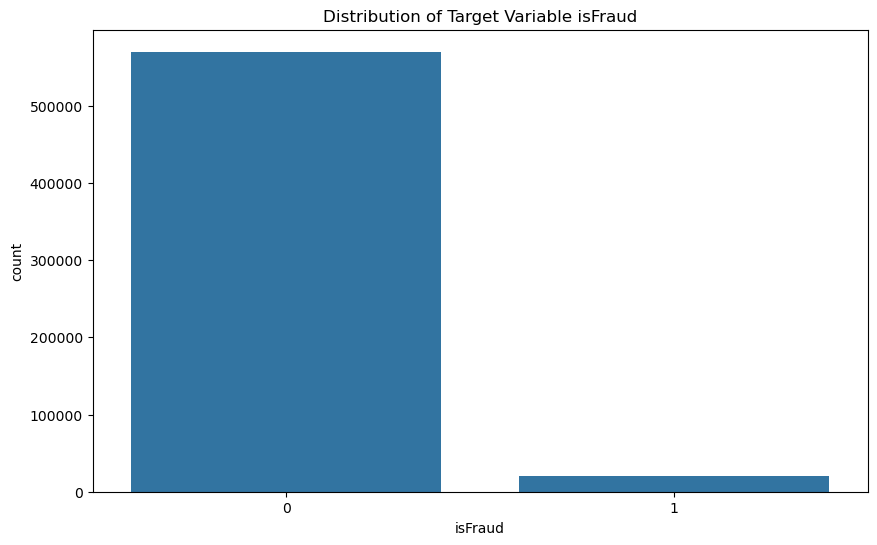

In [10]:
# Check distribution of target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='isFraud', data=train)
plt.title('Distribution of Target Variable isFraud')
plt.show()


In [11]:
# Compute fraud rate
fraud_ratio = train['isFraud'].mean() * 100
print(f'Fraud transaction rate: {fraud_ratio:.2f}%')
print(f'Number of fraudulent transactions: {train["isFraud"].sum()}')
print(f'Total number of transactions: {len(train)}')

Fraud transaction rate: 3.50%
Number of fraudulent transactions: 20663
Total number of transactions: 590540


In [12]:
# Check missing values in training data
missing_train = (train.isnull().sum() / len(train)) * 100


# Check missing values in test data
missing_test = (test.isnull().sum() / len(test)) * 100



In [13]:
missing_df = pd.DataFrame({'Train': missing_train, 'Test': missing_test})
missing_df = missing_df[missing_df.sum(axis=1) > 0].sort_values('Train', ascending=False)
print(missing_df)

           Train       Test
id_24  99.196159  99.064519
id_25  99.130965  99.005508
id_08  99.127070  99.001561
id_07  99.127070  99.001561
id_21  99.126393  99.001561
...          ...        ...
C6      0.000000   0.000592
C7      0.000000   0.000592
C8      0.000000   0.000592
C9      0.000000   0.000592
C1      0.000000   0.000592

[428 rows x 2 columns]


Analyze TransactionDT

In [14]:
# Convert TransactionDT to date
from datetime import datetime
START_DATE = '2017-12-01' # The dataset is assumed to start on this date
start_date = datetime.strptime(START_DATE, '%Y-%m-%d')

# Function to convert seconds to actual date
def convert_to_datetime(x):
    return start_date + pd.Timedelta(seconds=x)
# Apply to train and test datasets
train['TransactionDate'] = train['TransactionDT'].apply(convert_to_datetime)
test['TransactionDate'] = test['TransactionDT'].apply(convert_to_datetime)


# Add time-based features
for df in [train, test]:
    df['Day'] = df['TransactionDate'].dt.day
    df['Month'] = df['TransactionDate'].dt.month
    df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek  # Monday=0, Sunday=6
    df['Hour'] = df['TransactionDate'].dt.hour

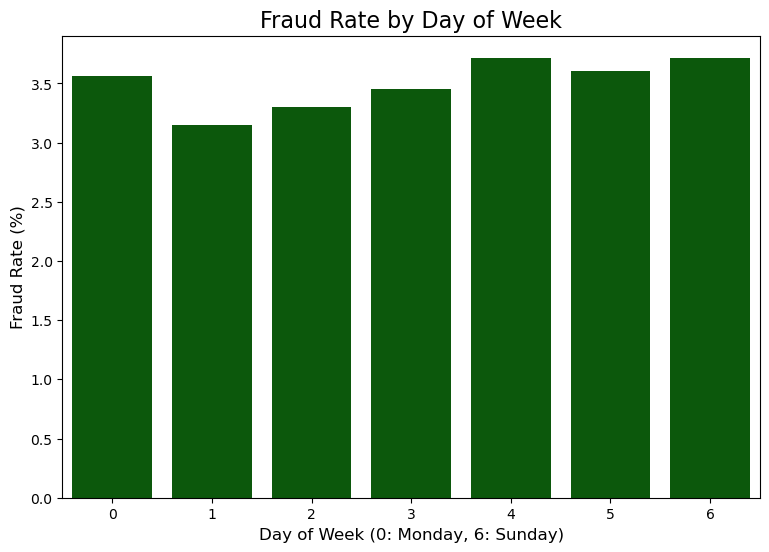

In [15]:
# Plots fraud rate (%) by day of week to detect which days are more active for frauds
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by day of week and calculate mean fraud rate (%) per day
fraud_by_day = train.groupby('DayOfWeek')['isFraud'].mean() * 100
plt.figure(figsize=(9, 6))

# Create barplot with a single solid dark blue color
sns.barplot(
    x=fraud_by_day.index,
    y=fraud_by_day.values,
    color='darkgreen'  )

# Add titles and labels for clarity
plt.title('Fraud Rate by Day of Week', fontsize=16)
plt.xlabel('Day of Week (0: Monday, 6: Sunday)', fontsize=12)
plt.ylabel('Fraud Rate (%)', fontsize=12)
plt.show()

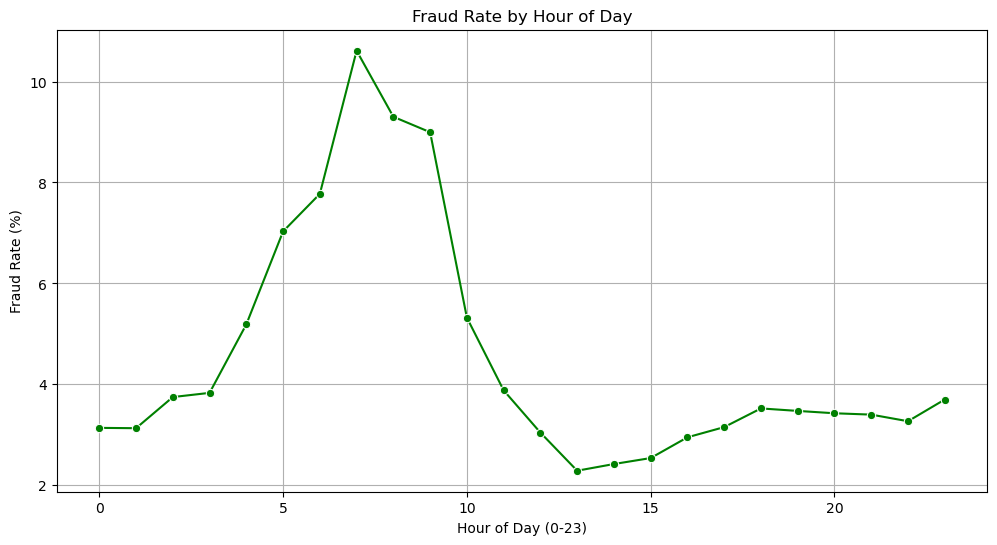

In [16]:
# Plots fraud rate (%) by hour to see peak fraud times
plt.figure(figsize=(12, 6))

# Calculate fraud rate (%) for each hour of the day
fraud_by_hour = train.groupby('Hour')['isFraud'].mean() * 100

# Plot fraud rate as a line plot with markers
sns.lineplot(
    x=fraud_by_hour.index,
    y=fraud_by_hour.values,
    marker='o',
    color='green'
)

# Add title and axis labels
plt.title('Fraud Rate by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)
plt.show()

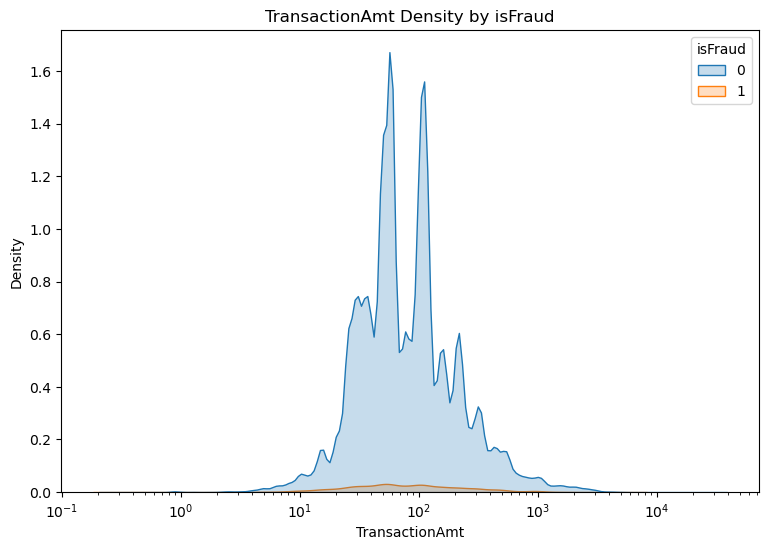

In [17]:
# Shows how transaction amounts differ between fraud and non-fraud
plt.figure(figsize=(9, 6))
sns.kdeplot(data=train, x='TransactionAmt', hue='isFraud', log_scale=True, fill=True)
plt.title('TransactionAmt Density by isFraud')
plt.show()

Visualize Features

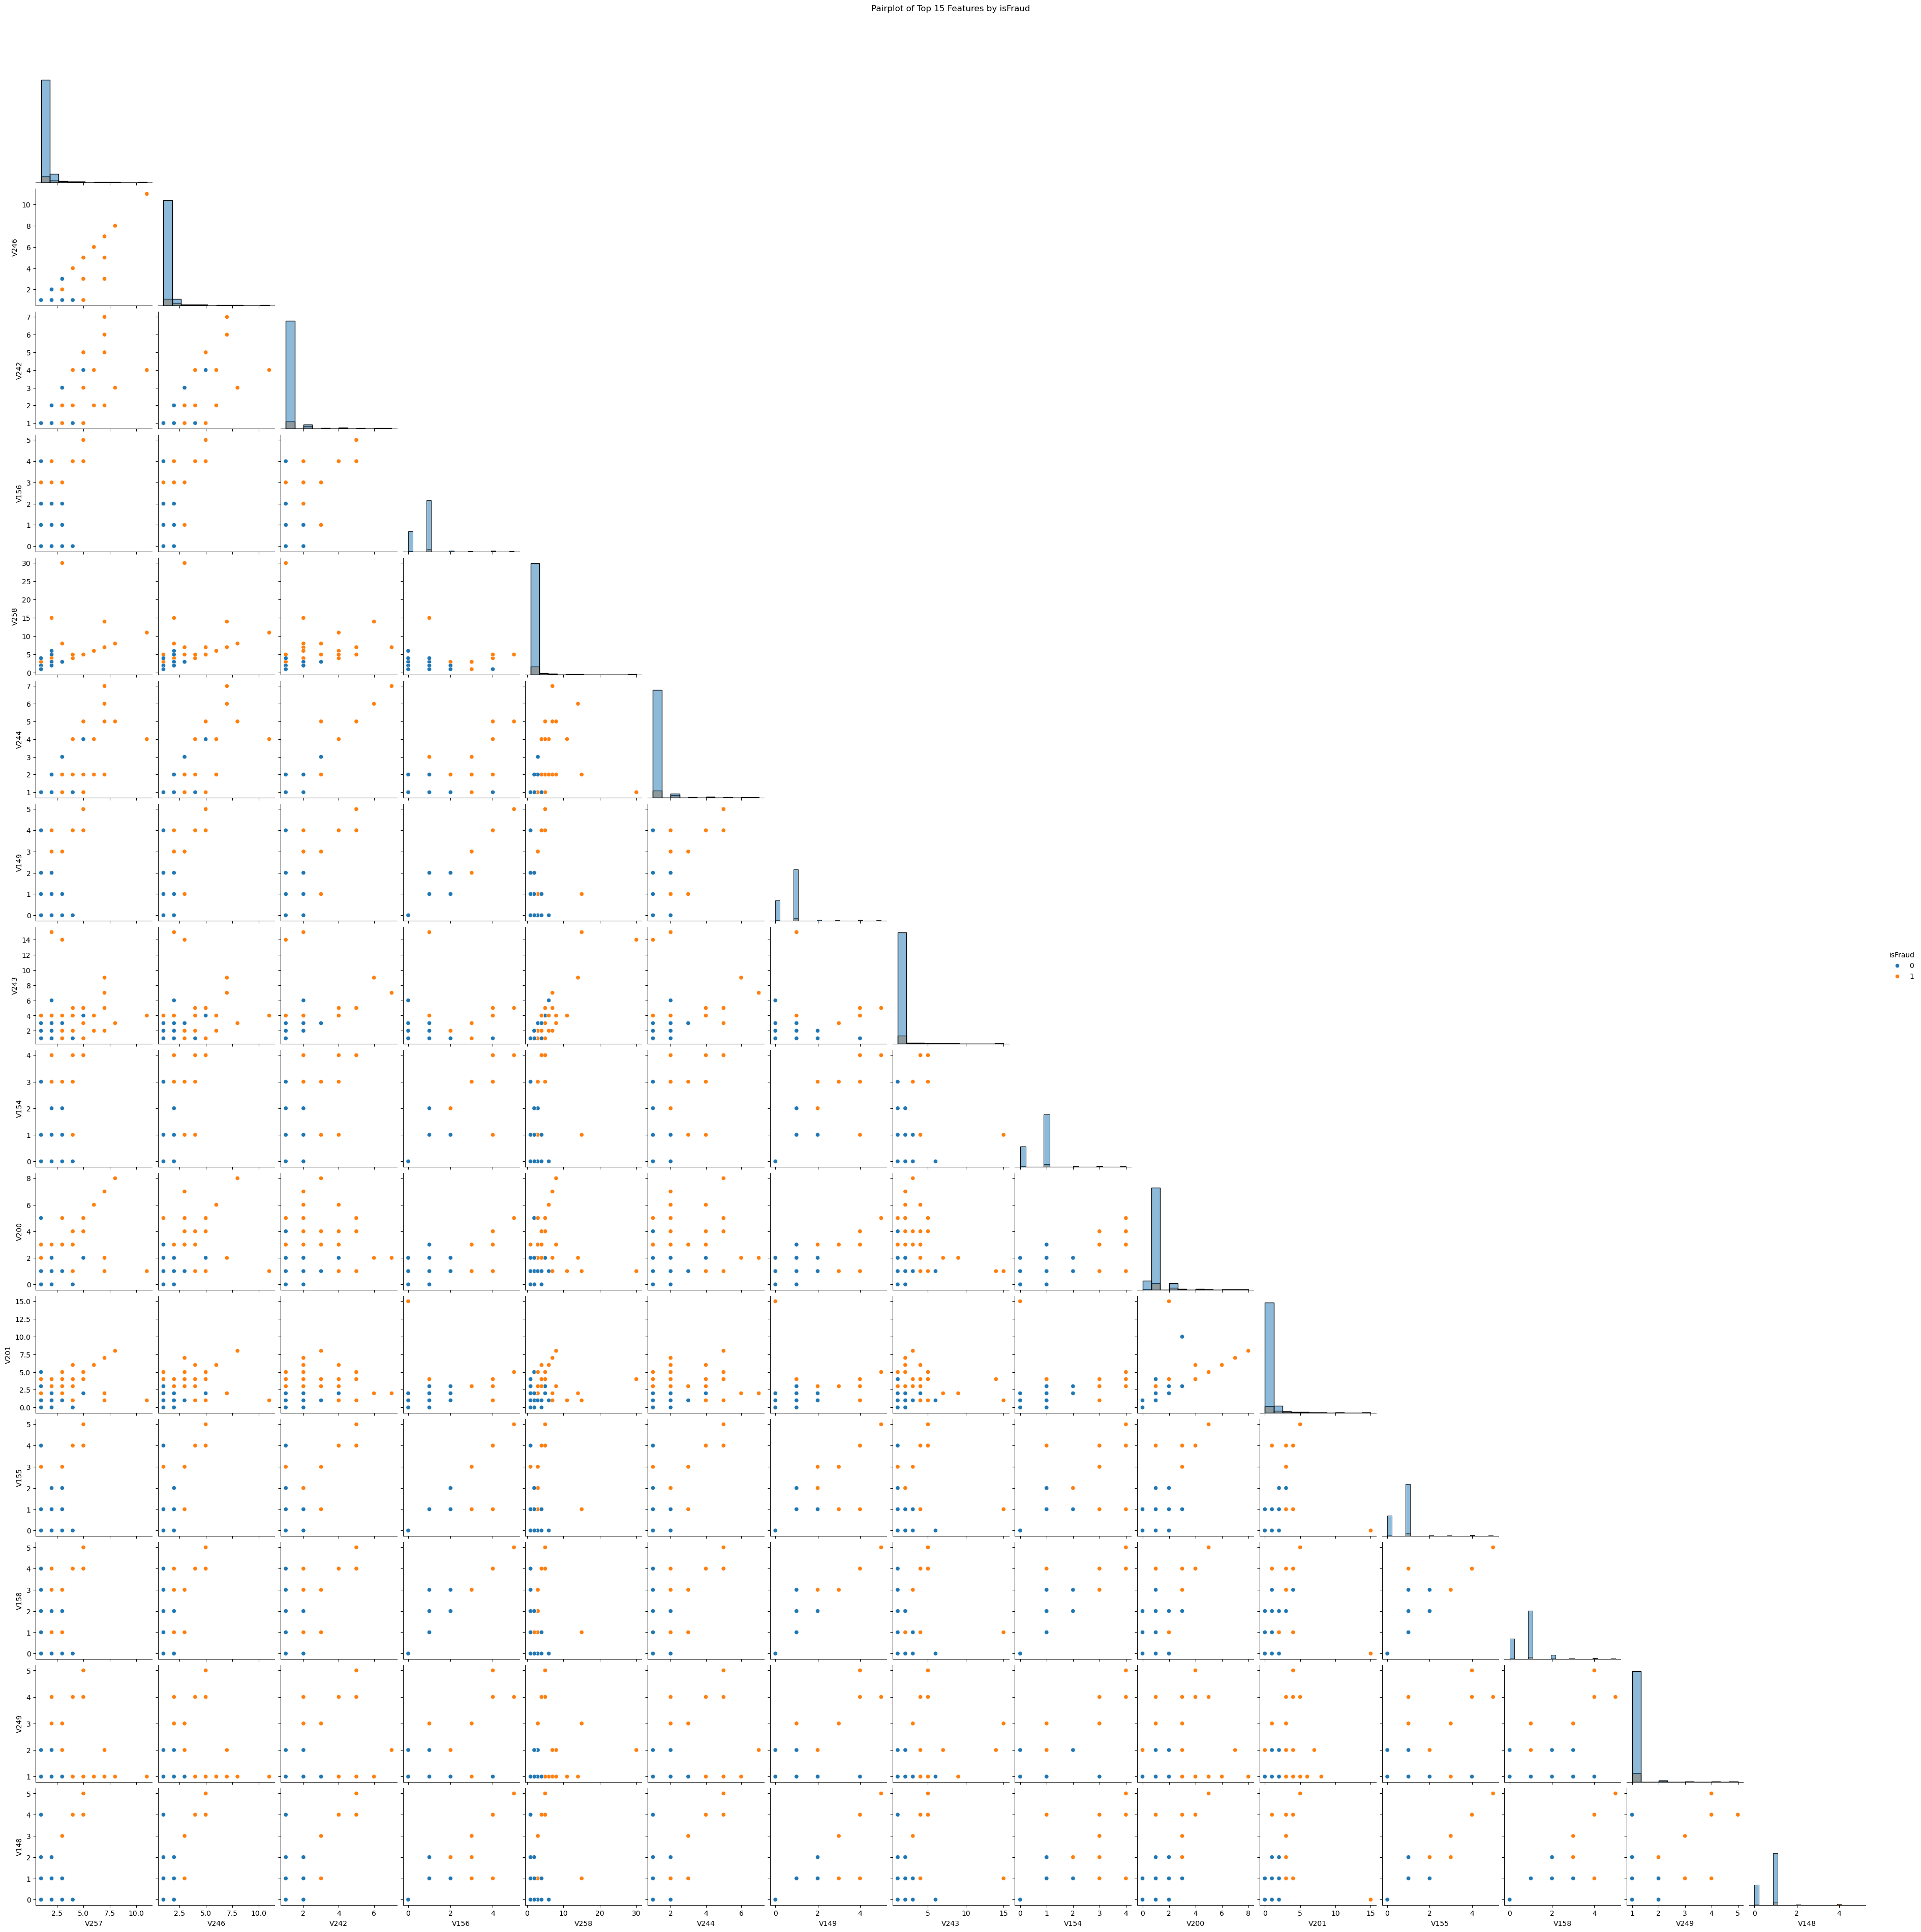

In [18]:
# Find top correlated with 'isFraud', and plot  a pairplot for the same
import seaborn as sns

sample = train.sample(5000, random_state=42)
# Select numerical features
numeric_cols = sample.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numeric_cols.corr()

# Get top correlated features with 'isFraud' (excluding 'isFraud' itself)
top_features = correlation_matrix['isFraud'].abs().sort_values(ascending=False).head(16).index
sns.pairplot(sample, vars=top_features.drop('isFraud'), hue='isFraud', diag_kind='hist', corner=True)
plt.suptitle('Pairplot of Top 15 Features by isFraud', y=1.02)
plt.show()


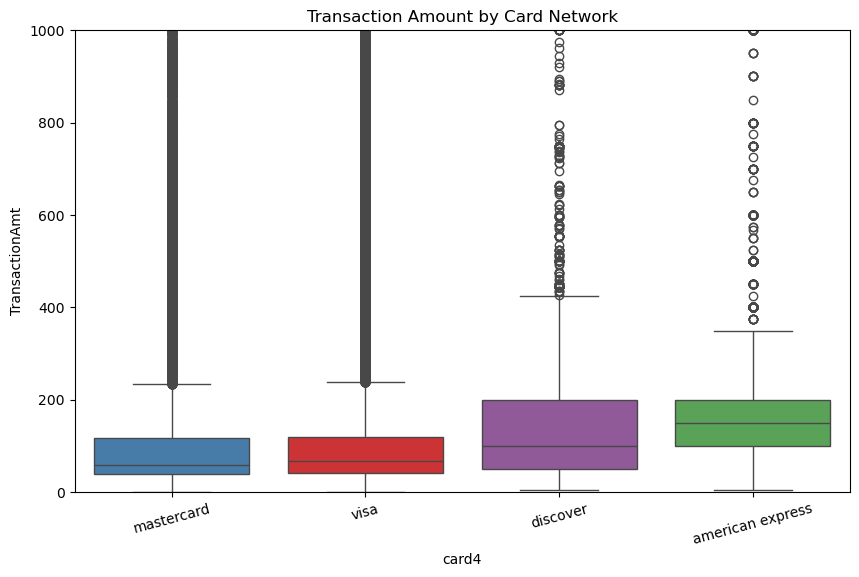

In [19]:
# This plot shows the distribution of Transaction Amounts for each card network (card4).
# It helps identify if certain card types are more prone to frauds (e.g. Visa, Mastercard, American Express)

plt.figure(figsize=(10, 6))
sns.boxplot(x='card4', y='TransactionAmt', data=df, order=df.groupby('card4')['TransactionAmt'].median().sort_values().index,hue='card4',legend=False, palette='Set1')
plt.ylim(0, 1000)
plt.title("Transaction Amount by Card Network")
plt.xticks(rotation=15)
plt.show()

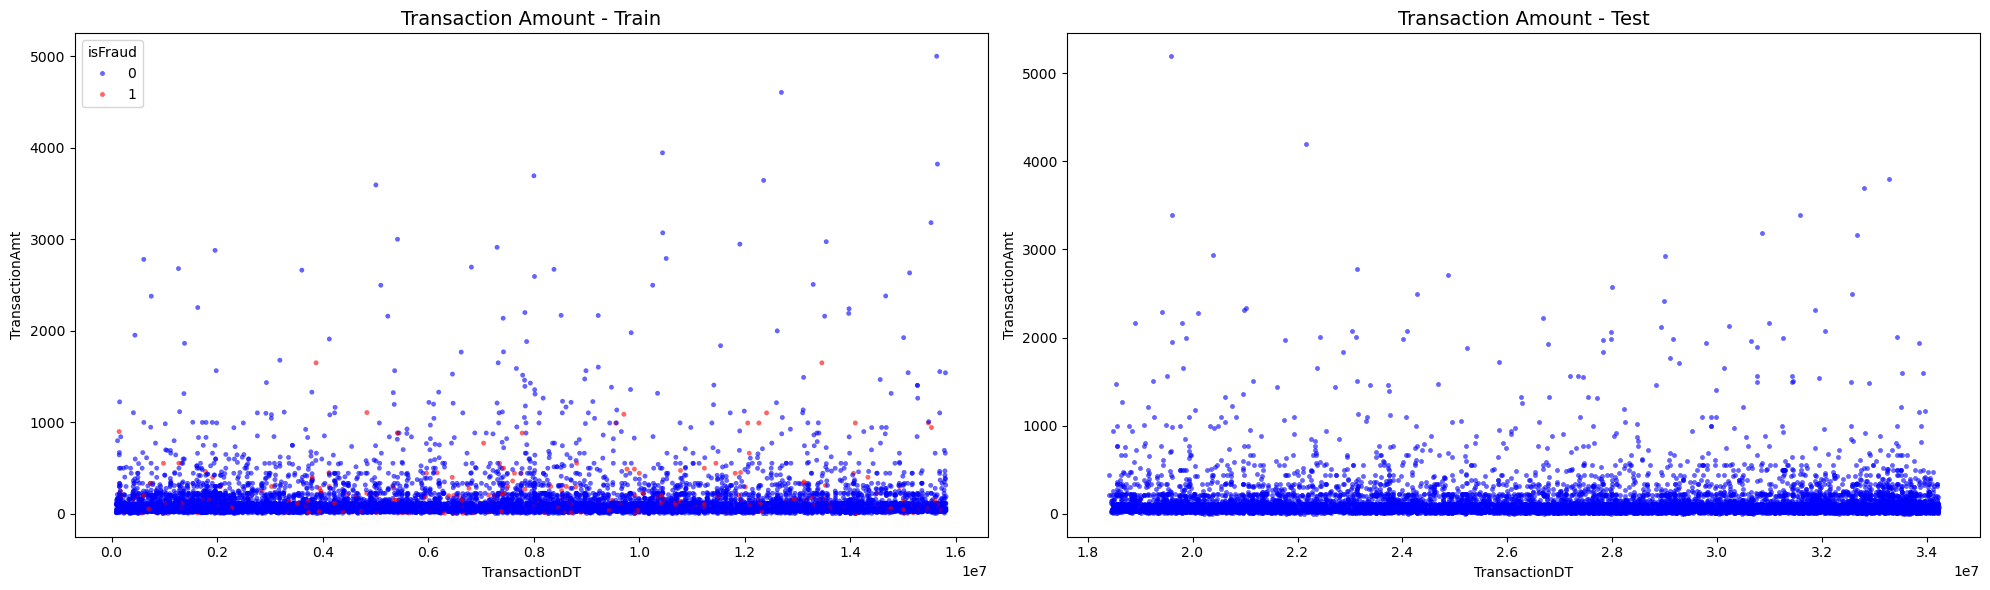

In [20]:
# Visualise transaction data distributionin test and training datasets
plt.figure(figsize=(20, 6))

# ---------------- Train Plot ----------------
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=train.sample(10000),  # Sample for performance
    x='TransactionDT',
    y='TransactionAmt',
    hue='isFraud',
    palette={0: 'blue', 1: 'red'},
    alpha=0.6,
    edgecolor=None,
    s=10,
)
plt.title('Transaction Amount - Train', fontsize=14)
plt.xlabel('TransactionDT')
plt.ylabel('TransactionAmt')
plt.legend(title='isFraud')

# ---------------- Test Plot ----------------
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=test.sample(10000),
    x='TransactionDT',
    y='TransactionAmt',
    color='blue',
    alpha=0.6,
    edgecolor=None,
    s=10,
)
plt.title('Transaction Amount - Test', fontsize=14)
plt.xlabel('TransactionDT')
plt.ylabel('TransactionAmt')

plt.tight_layout()
plt.show()

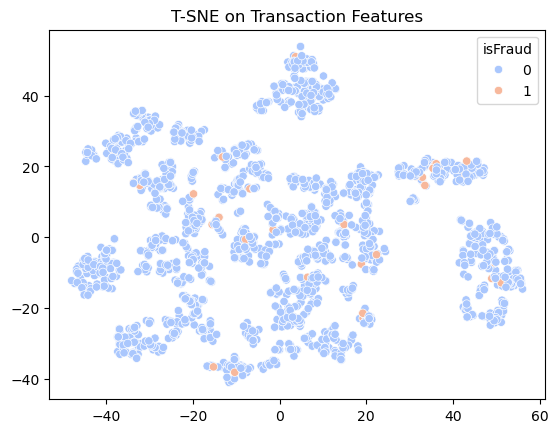

In [21]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = ['TransactionAmt', 'card1', 'card2', 'addr1', 'addr2', 'dist1']
sample = train.sample(5000, random_state=42).dropna(subset=features)

X = StandardScaler().fit_transform(sample[features])
y = sample['isFraud']

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette='coolwarm')
plt.title('T-SNE on Transaction Features')
plt.show()


Data Preprocessing

In [22]:
# Handle missing values
def handle_missing_values(df):
    """
    Handle missing values for numeric and categorical columns
    """
    for col in df.columns:
        if col in ['TransactionID', 'isFraud', 'TransactionDate']:
            continue

        if df[col].dtype != 'object':
            df[col] = df[col].fillna(-999)
        else:
            df[col] = df[col].fillna('missing')

    return df

In [23]:
# Apply to both train and test
train = handle_missing_values(train)
test = handle_missing_values(test)


In [24]:
# Check missing values
print("Missing values after handling:")
print(f"Train: {train.isnull().sum().sum()}")
print(f"Test: {test.isnull().sum().sum()}")

Missing values after handling:
Train: 0
Test: 0


In [25]:
# ============================
# Flexible Label Encoding Function
# ============================
def label_encode(df_train, df_test, cols):
    """
    Label encodes categorical columns in both train and test datasets.
    Fits on combined unique values to ensure consistent encoding.
    """
    from sklearn.preprocessing import LabelEncoder

    df_train = df_train.copy()
    df_test = df_test.copy()

    print("--- Starting Flexible Label Encoding ---")

    for col in cols:
        # Check if column exists in train/test
        train_exists = col in df_train.columns
        test_exists = col in df_test.columns

        # Check if column is object type in train or test
        is_object = (train_exists and df_train[col].dtype == 'object') or \
                    (test_exists and df_test[col].dtype == 'object')

        if not (train_exists or test_exists) or not is_object:
            continue  # Skip non-object columns

        print(f"Processing column: '{col}'")

        le = LabelEncoder()
        values_to_fit = []

        # Gather values from train
        if train_exists and df_train[col].dtype == 'object':
            values_to_fit.extend(df_train[col].astype(str).values)
            print(f"  Found object column '{col}' in train.")

        # Gather values from test
        if test_exists and df_test[col].dtype == 'object':
            values_to_fit.extend(df_test[col].astype(str).values)
            print(f"  Found object column '{col}' in test.")

        # Fit LabelEncoder on combined unique values
        unique_values = pd.Series(values_to_fit).unique()
        if len(unique_values) > 0:
            le.fit(unique_values)
            print(f"  Fitted LabelEncoder for '{col}' on {len(unique_values)} unique values.")

            # Transform train
            if train_exists and df_train[col].dtype == 'object':
                df_train[col] = le.transform(df_train[col].astype(str))
                print(f"  Transformed train column '{col}'.")

            # Transform test
            if test_exists and df_test[col].dtype == 'object':
                df_test[col] = le.transform(df_test[col].astype(str))
                print(f"  Transformed test column '{col}'.")
        else:
            print(f"  Skipping '{col}': No valid values found.")

    print("--- Finished Flexible Label Encoding ---")
    return df_train, df_test

# ============================
# Identify Categorical Columns
# ============================

# General object columns
categorical_cols = [col for col in train.columns if train[col].dtype == 'object']

# Columns starting with 'M'
m_cols = [col for col in train.columns if col.startswith('M')]

# id_ columns with id_12 and above
id_cols = [col for col in train.columns if col.startswith('id_') and int(col.split('_')[1]) >= 12]

# uid columns
uid_cols = [col for col in train.columns if col.startswith('uid')]

# Combine all categorical columns uniquely
categorical_cols = list(set(categorical_cols + m_cols + id_cols + uid_cols))

print(f"Total categorical columns identified: {len(categorical_cols)}")

# ============================
# Apply Label Encoding
# ============================

train, test = label_encode(train, test, categorical_cols)

# ============================
# Check remaining object columns
# ============================
print("Remaining object columns in train:", [col for col in train.columns if train[col].dtype == 'object'])
print("Remaining object columns in test:", [col for col in test.columns if test[col].dtype == 'object'])
print("Sample encoded categorical columns:", categorical_cols[:10])


Total categorical columns identified: 44
--- Starting Flexible Label Encoding ---
Processing column: 'id_16'
  Found object column 'id_16' in train.
  Found object column 'id_16' in test.
  Fitted LabelEncoder for 'id_16' on 3 unique values.
  Transformed train column 'id_16'.
  Transformed test column 'id_16'.
Processing column: 'DeviceInfo'
  Found object column 'DeviceInfo' in train.
  Found object column 'DeviceInfo' in test.
  Fitted LabelEncoder for 'DeviceInfo' on 2800 unique values.
  Transformed train column 'DeviceInfo'.
  Transformed test column 'DeviceInfo'.
Processing column: 'card6'
  Found object column 'card6' in train.
  Found object column 'card6' in test.
  Fitted LabelEncoder for 'card6' on 5 unique values.
  Transformed train column 'card6'.
  Transformed test column 'card6'.
Processing column: 'M8'
  Found object column 'M8' in train.
  Found object column 'M8' in test.
  Fitted LabelEncoder for 'M8' on 3 unique values.
  Transformed train column 'M8'.
  Transform

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from scipy.stats import randint
from sklearn.feature_selection import SelectKBest, f_classif # For feature selection
import sys # To check memory usage

# --- Configuration for Optimization ---
N_FEATURES_TO_SELECT = 5000
MAX_ROWS_FOR_FEATURE_SELECTION = 200000
MAX_ROWS_FOR_HYPERPARAMETER_TUNING = 100000


# --- Step 1: Separate features and target ---
target = 'isFraud'
drop_cols = ['TransactionID', 'TransactionDate', target]

# Select only numeric columns for features
X_all = train.drop(columns=drop_cols, errors='ignore').select_dtypes(include=[np.number])
y_all = train[target]

print(f"Original full numeric features shape: {X_all.shape}")

# --- Downcast Data Types to save memory ---
print("Downcasting numeric features to float32...")
for col in X_all.columns:
    if X_all[col].dtype == 'float64':
        X_all[col] = X_all[col].astype('float32')
    # Can also consider int32 for appropriate integer columns if needed
    # elif X_all[col].dtype == 'int64':
    #     X_all[col] = X_all[col].astype('int32')
print(f"Memory usage after downcasting: {X_all.memory_usage(deep=True).sum() / (1024**2):.2f} MB")


# --- Step 2: Feature Selection (Crucial for MemoryError) ---
print(f"Performing feature selection: selecting top {N_FEATURES_TO_SELECT} features...")

# Create a temporary sample for feature selection if the dataset is too large.
# This helps prevent memory issues during the selector.fit() step.
X_temp_for_selection = X_all.copy()
y_temp_for_selection = y_all.copy()

if X_temp_for_selection.shape[0] > MAX_ROWS_FOR_FEATURE_SELECTION:
    print(f"Sampling {MAX_ROWS_FOR_FEATURE_SELECTION} rows for feature selection due to large dataset.")
    # Use np.random.choice for sampling indices
    sample_indices = np.random.choice(X_temp_for_selection.index, size=MAX_ROWS_FOR_FEATURE_SELECTION, replace=False)
    X_temp_for_selection = X_temp_for_selection.loc[sample_indices]
    y_temp_for_selection = y_temp_for_selection.loc[sample_indices]

# Handle NaNs in X_temp_for_selection and y_temp_for_selection for feature selection.
# SelectKBest (f_classif) cannot handle NaNs, so rows with NaNs are dropped for this step.
# For a more robust approach, consider imputation (e.g., SimpleImputer) before feature selection.
nan_rows_for_selection = X_temp_for_selection.isnull().any(axis=1) | y_temp_for_selection.isnull()
if nan_rows_for_selection.any():
    print(f"Dropping {nan_rows_for_selection.sum()} rows with NaNs for feature selection.")
    X_temp_for_selection = X_temp_for_selection[~nan_rows_for_selection]
    y_temp_for_selection = y_temp_for_selection[~nan_rows_for_selection]

# Create and fit the selector
selector = SelectKBest(f_classif, k=N_FEATURES_TO_SELECT)
selector.fit(X_temp_for_selection, y_temp_for_selection)

# Get the selected features from the *original* X_all based on the selector fitted on the sample
selected_features_mask = selector.get_support()
X_selected = X_all.loc[:, selected_features_mask] # Use .loc with boolean mask for column selection

print(f"Shape of X after feature selection: {X_selected.shape}")
print(f"Memory usage after feature selection: {X_selected.memory_usage(deep=True).sum() / (1024**2):.2f} MB")


# Step 3: Train/Validation Split for the *full* selected dataset ---
# This split is for the final model training and evaluation, not for hyperparameter tuning directly.
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_selected, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Ensure y_train_full and y_val_full don't have NaNs.
# If NaNs are present, drop corresponding rows to ensure clean data for training.
if y_train_full.isnull().any() or y_val_full.isnull().any():
    print("NaNs detected in y_train_full/y_val_full. Dropping corresponding rows.")
    train_indices = y_train_full.dropna().index
    val_indices = y_val_full.dropna().index
    X_train_full = X_train_full.loc[train_indices]
    y_train_full = y_train_full.loc[train_indices]
    X_val_full = X_val_full.loc[val_indices]
    y_val_full = y_val_full.loc[val_indices]

print(f"Shape of X_train_full (for final fit): {X_train_full.shape}")
print(f"Shape of X_val_full (for final evaluation): {X_val_full.shape}")


# --- Step 4: Create a smaller sample for Hyperparameter Tuning ---
# This sample is used by RandomizedSearchCV to find the best parameters efficiently.
X_train_sample, y_train_sample = X_train_full, y_train_full # Initialize with full set

if X_train_full.shape[0] > MAX_ROWS_FOR_HYPERPARAMETER_TUNING:
    print(f"Creating a sample of {MAX_ROWS_FOR_HYPERPARAMETER_TUNING} rows for hyperparameter tuning.")
    # Use train_test_split to get a stratified sample of the desired size.
    # The 'test_size' here defines the size of the *sample* we want to use for tuning.
    # We discard the 'train' part of this split and use the 'test' part as our sample.
    _, X_train_sample, _, y_train_sample = train_test_split(
        X_train_full, y_train_full,
        test_size=MAX_ROWS_FOR_HYPERPARAMETER_TUNING, # This is the size of the sample we want
        stratify=y_train_full,
        random_state=42
    )
    print(f"Shape of X_train_sample (for tuning): {X_train_sample.shape}")


# --- Step 5: Initialize RandomForestClassifier and RandomizedSearchCV ---
rf = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': randint(5, 15), # Increased from 5 to 15, adjust based on performance vs memory
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10, # Number of parameter settings that are sampled
    scoring='roc_auc',
    cv=3, # Number of folds in cross-validation
    verbose=2, # Controls the verbosity: higher values mean more messages
    random_state=42,
    n_jobs=-1 # Using all available CPU cores.
)

# Fit RandomizedSearchCV on the *sample* for efficient hyperparameter tuning
print("\nStarting RandomizedSearchCV on a sample for hyperparameter tuning...")
random_search.fit(X_train_sample, y_train_sample)
best_params = random_search.best_params_

print("\n✅ RandomizedSearchCV complete.")
print("\n✅ Best Parameters (from sample tuning):", best_params)

# --- Step 6: Train the final model on the *entire* training set (X_train_full) with best parameters ---
print("\nTraining final model on the entire training set with best parameters...")
final_rf_model = RandomForestClassifier(random_state=42, **best_params)
final_rf_model.fit(X_train_full, y_train_full)

print("\n✅ Final model training complete.")

# --- Step 7: Evaluate the final model on the full validation set ---
print("\nEvaluating the final model on the full validation set...")
y_pred_proba = final_rf_model.predict_proba(X_val_full)[:, 1]
y_pred = final_rf_model.predict(X_val_full)

print("\n✅ ROC-AUC Score:", roc_auc_score(y_val_full, y_pred_proba))
print("\n✅ Classification Report:\n", classification_report(y_val_full, y_pred))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_val_full, y_pred))

Original full numeric features shape: (590540, 437)
Downcasting numeric features to float32...
Memory usage after downcasting: 988.95 MB
Performing feature selection: selecting top 5000 features...
Sampling 200000 rows for feature selection due to large dataset.


C:\Users\ROG\anaconda3\envs\fraud-detect-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=5000 is greater than n_features=437. All the features will be returned.
  warnings.warn(


Shape of X after feature selection: (590540, 437)
Memory usage after feature selection: 988.95 MB
Shape of X_train_full (for final fit): (472432, 437)
Shape of X_val_full (for final evaluation): (118108, 437)
Creating a sample of 100000 rows for hyperparameter tuning.
Shape of X_train_sample (for tuning): (100000, 437)

Starting RandomizedSearchCV on a sample for hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ RandomizedSearchCV complete.

✅ Best Parameters (from sample tuning): {'max_depth': 12, 'min_samples_leaf': 1, 'n_estimators': 149}

Training final model on the entire training set with best parameters...

✅ Final model training complete.

Evaluating the final model on the full validation set...

✅ ROC-AUC Score: 0.8772735710684025

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.94      0.30      0.46      4133

    accuracy        

Datetime columns: ['TransactionDate']
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.933839	val's auc: 0.916249
[200]	train's auc: 0.939726	val's auc: 0.920788
[300]	train's auc: 0.944281	val's auc: 0.925041
[400]	train's auc: 0.947016	val's auc: 0.927387
[500]	train's auc: 0.95019	val's auc: 0.929978
[600]	train's auc: 0.953928	val's auc: 0.932783
[700]	train's auc: 0.958073	val's auc: 0.93574
[800]	train's auc: 0.961582	val's auc: 0.938315
[900]	train's auc: 0.964709	val's auc: 0.940496
[1000]	train's auc: 0.96744	val's auc: 0.9426
[1100]	train's auc: 0.970271	val's auc: 0.944621
[1200]	train's auc: 0.972196	val's auc: 0.945966
[1300]	train's auc: 0.974012	val's auc: 0.947324
[1400]	train's auc: 0.975744	val's auc: 0.948494
[1500]	train's auc: 0.977179	val's auc: 0.949457
[1600]	train's auc: 0.978592	val's auc: 0.950357
[1700]	train's auc: 0.979701	val's auc: 0.95123
[1800]	train's auc: 0.980656	val's auc: 0.951967
[1900]	train's auc: 0.98174	val's

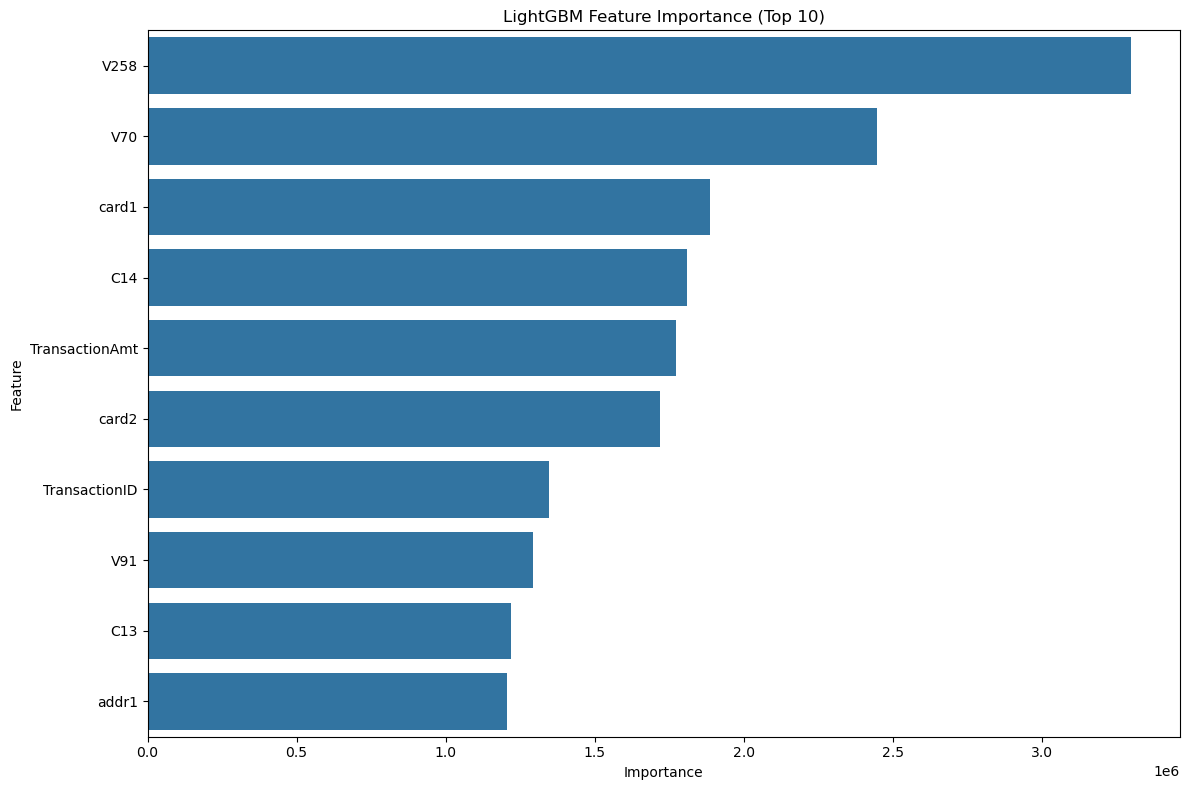

In [44]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Separate features and target ---
X = train.drop(columns=['isFraud'])
y = train['isFraud']

# --- Step 2: Handle datetime columns ---
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns.tolist()
print("Datetime columns:", datetime_cols)

# Convert datetime to Unix timestamp (seconds since epoch)
for col in datetime_cols:
    X[col] = X[col].astype('int64') // 10**9  # or .view('int64') // 10**9

# --- Step 3: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

# --- Step 4: LightGBM parameters ---
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.01,
    'num_leaves': 256,
    'max_depth': 8,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'min_child_weight': 1,
    'min_child_samples': 20,
    'scale_pos_weight': y_train.value_counts()[0] / y_train.value_counts()[1],  # handle imbalance
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'verbose': -1
}

# --- Step 5: Create LightGBM datasets ---
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_val = lgb.Dataset(X_test, label=y_test, reference=lgb_train, free_raw_data=False)

# --- Step 6: Train model with early stopping ---
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

# --- Step 7: Predict on test ---
val_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
val_auc = roc_auc_score(y_test, val_pred)
print(f"LightGBM Validation AUC: {val_auc:.6f}")

# Convert predicted probabilities to class labels (threshold=0.5)
val_pred_labels = (val_pred > 0.5).astype(int)

# --- Step 8: Print classification report and confusion matrix ---
print("\nClassification Report:\n", classification_report(y_test, val_pred_labels))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, val_pred_labels))

# --- Step 9: Plot Feature Importance ---
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title("LightGBM Feature Importance (Top 10)")
plt.tight_layout()
plt.show()



--- Starting XGBoost Model Training ---
[0]	train-auc:0.86552	val-auc:0.85290
[100]	train-auc:0.94655	val-auc:0.92754
[200]	train-auc:0.97266	val-auc:0.94646
[300]	train-auc:0.98368	val-auc:0.95481
[400]	train-auc:0.98984	val-auc:0.95961
[500]	train-auc:0.99383	val-auc:0.96327
[600]	train-auc:0.99609	val-auc:0.96532
[700]	train-auc:0.99744	val-auc:0.96677
[800]	train-auc:0.99838	val-auc:0.96786
[900]	train-auc:0.99902	val-auc:0.96865
[1000]	train-auc:0.99941	val-auc:0.96924
[1100]	train-auc:0.99965	val-auc:0.96992
[1200]	train-auc:0.99979	val-auc:0.97031
[1300]	train-auc:0.99988	val-auc:0.97061
[1400]	train-auc:0.99993	val-auc:0.97098
[1500]	train-auc:0.99996	val-auc:0.97135
[1600]	train-auc:0.99998	val-auc:0.97149
[1700]	train-auc:0.99999	val-auc:0.97175
[1800]	train-auc:0.99999	val-auc:0.97193
[1900]	train-auc:1.00000	val-auc:0.97216
[2000]	train-auc:1.00000	val-auc:0.97237
[2100]	train-auc:1.00000	val-auc:0.97247
[2200]	train-auc:1.00000	val-auc:0.97255
[2300]	train-auc:1.00000	val

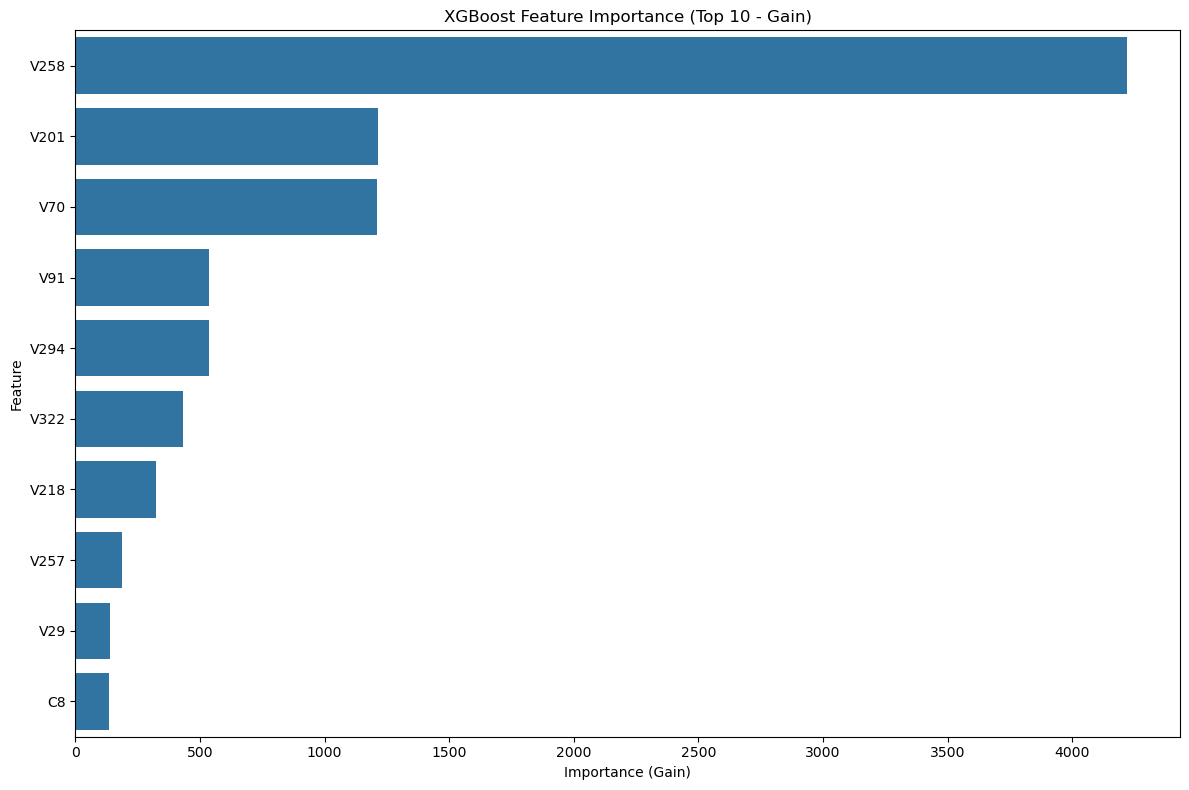


--- Saving the trained model to xgb_fraud.pkl ---
Model saved successfully!


1146

In [45]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import joblib 

# ⚙ Set XGBoost parameters
# Handle imbalance by calculating scale_pos_weight
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count if pos_count > 0 else 1.0

xgb_params = {
    'objective': 'binary:logistic', # For binary classification, outputs probabilities
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 8,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1, # L1 regularization
    'lambda': 0.1, # L2 regularization
    'tree_method': 'hist', # 'gpu_hist' if you have GPU and it's configured
    'nthread': -1, # Use all available threads
    'scale_pos_weight': scale_pos_weight_value, # handle imbalance
    'seed': 42
}

# Create DMatrix for train and validation
# Ensure X_train and X_test are passed as numpy arrays or pandas DataFrames
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dval, 'val')]

print("\n--- Starting XGBoost Model Training ---")
# Train model with early stopping
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=10000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=100
)

print(f"\nTraining finished. Best iteration: {xgb_model.best_iteration}")

# Predict on validation set
# For a binary:logistic objective, predict() directly returns probabilities
val_pred = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
val_auc = roc_auc_score(y_test, val_pred)
print(f"\n✅ XGBoost Validation AUC: {val_auc:.6f}")

# Threshold predictions to get binary labels
# You might want to optimize this threshold for your specific problem
optimal_threshold = 0.5 # Default, consider ROC curve or PR curve for optimization
val_pred_labels = (val_pred > optimal_threshold).astype(int)

# Classification report and confusion matrix
print("\n✅ Classification Report:\n", classification_report(y_test, val_pred_labels))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, val_pred_labels))

# Feature importance plotting
# Ensure feature_names matches the actual column names or indices
feature_names = X_train.columns.tolist() if isinstance(X_train, pd.DataFrame) else [f'feature_{i}' for i in range(X_train.shape[1])]
importance_dict = xgb_model.get_score(importance_type='gain')

# Create a full list of feature importances, ensuring all features are covered
feature_importances = {name: importance_dict.get(name, 0.0) for name in feature_names}
xgb_importance = pd.DataFrame({
    'Feature': feature_importances.keys(),
    'Importance': feature_importances.values()
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=xgb_importance.head(10))
plt.title('XGBoost Feature Importance (Top 10 - Gain)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# --- Feature Engineering  ---
card4_map = {"Visa": 1, "MasterCard": 2, "Discover": 3, "American Express": 4, "Other": 0}
device_map = {"desktop": 0, "mobile": 1}
browser_map = {"chrome": 1, "safari": 2, "firefox": 3, "edge": 4, "other": 0}

train['email_match'] = (train['P_emaildomain'] == train['R_emaildomain']).astype(int)

# Map features to feature_0 ... feature_19
feature_dict = {
    'feature_0': train['TransactionAmt'],
    'feature_1': train['card1'],
    'feature_2': train['card4'].map(card4_map).fillna(0),
    'feature_3': train['DeviceType'].map(device_map).fillna(0),
    'feature_4': train['id_31'].map(browser_map).fillna(0),
    'feature_5': train['D1'],
    'feature_6': train['email_match'],
    # Add your mappings for feature_7 to feature_19 here, or fill with 0.0
}

# Fill remaining features with 0 or another default
for i in range(7, 20):
    feature_dict[f'feature_{i}'] = 0.0  # Or use train['some_other_feature'] if available

X = pd.DataFrame(feature_dict)
y = train['isFraud']  # Replace with your actual target column

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle imbalance
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight_value = neg_count / pos_count if pos_count > 0 else 1.0

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.03,
    'max_depth': 4,
    'min_child_weight': 5,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'alpha': 2.0,
    'lambda': 2.0,
    'tree_method': 'hist',
    'nthread': -1,
    'scale_pos_weight': scale_pos_weight_value,
    'seed': 42
}


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)
evals = [(dtrain, 'train'), (dval, 'val')]

print("\n--- Starting XGBoost Model Training ---")
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=10000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=100
)

print(f"\nTraining finished. Best iteration: {xgb_model.best_iteration}")

# --- Predict on validation set ---
# For a binary:logistic objective, predict() directly returns probabilities
val_pred = xgb_model.predict(dval, iteration_range=(0, xgb_model.best_iteration + 1))
val_auc = roc_auc_score(y_test, val_pred)
print(f"\n✅ XGBoost Validation AUC: {val_auc:.6f}")

# Save the model
joblib.dump(xgb_model, "xgb_fraud.pkl")
print("Model saved as xgb_fraud.pkl")


--- Starting XGBoost Model Training ---
[0]	train-auc:0.66164	val-auc:0.66346
[100]	train-auc:0.76492	val-auc:0.76420
[200]	train-auc:0.77802	val-auc:0.77550
[300]	train-auc:0.78689	val-auc:0.78322
[400]	train-auc:0.79387	val-auc:0.78887
[500]	train-auc:0.79946	val-auc:0.79359
[600]	train-auc:0.80377	val-auc:0.79670
[700]	train-auc:0.80782	val-auc:0.79989
[800]	train-auc:0.81119	val-auc:0.80269
[900]	train-auc:0.81424	val-auc:0.80504
[1000]	train-auc:0.81713	val-auc:0.80703
[1100]	train-auc:0.81977	val-auc:0.80892
[1200]	train-auc:0.82204	val-auc:0.81064
[1300]	train-auc:0.82421	val-auc:0.81199
[1400]	train-auc:0.82661	val-auc:0.81377
[1500]	train-auc:0.82846	val-auc:0.81511
[1600]	train-auc:0.83040	val-auc:0.81659
[1700]	train-auc:0.83228	val-auc:0.81790
[1800]	train-auc:0.83395	val-auc:0.81897
[1900]	train-auc:0.83531	val-auc:0.81983
[2000]	train-auc:0.83663	val-auc:0.82073
[2100]	train-auc:0.83795	val-auc:0.82167
[2200]	train-auc:0.83905	val-auc:0.82251
[2300]	train-auc:0.84025	val